In [47]:
%run algebra.py
%run cache.py
%run costs.py
%run features.py
%run gradients.py
%run helpers.py
%run model.py
%run models.py
%run splits.py

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import csv
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [5]:
def load_csv_data(data_path, sub_sample=True):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    ids = x[:, 0].astype(np.int)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1

    # sub-sample
    if sub_sample:
        yb = yb[::50]
        input_data = input_data[::50]
        ids = ids[::50]

    return yb, input_data, ids

In [6]:
y, x, ids = load_csv_data('data/train.csv')

# 1 - Only Using Clean Features

### Ridge Regression with Fixed Degree

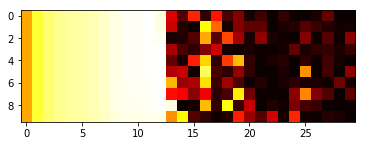

{'degree': 12.0, 'lambda': 2.1544346900318823e-05, 'mse': 0.27156314426523304}

In [4]:
myModel = RidgeRegression_MSE_Degree_Model(x, y)

res = myModel.evaluate(hs={ 
    'degree': np.arange(30), 
    'lambda': np.logspace(-8, -2, 10)
}, filename='results/RidgeRegression_MSE_Degree_Model')

res_mse = np.vectorize(lambda x: x['mse'])(res)

plt.imshow(1 / res_mse, cmap='hot', interpolation='nearest')
plt.show()

ii = np.where(res_mse == res_mse.min())
i, j = ii[0][0], ii[1][0]

res[i, j]

### Least Squares

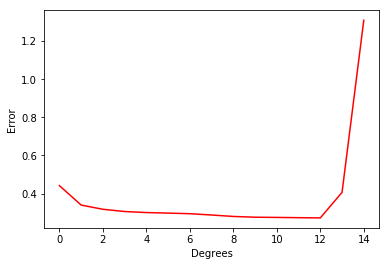

{'degree': 12.0, 'mse': 0.27188712714910396}

In [54]:
myModel = LeastSquare_MSE_Degree_Model(x, y)

degrees = np.arange(15)

res = myModel.evaluate(hs={ 
    'degree': degrees
}, filename='results/LeastSquare_MSE_Degree_Model')

res_mse = np.vectorize(lambda x: x['mse'])(res)

plt.figure(2)
plt.plot(degrees, res_mse, 'r')
plt.xlabel('Degrees')
plt.ylabel('Error')
plt.show()

ii = np.where(res_mse == res_mse.min())
i = ii[0][0]

res[i]

### Stochastic Gradient Descent with Fixed Degree

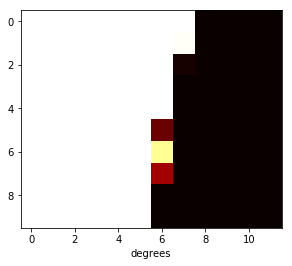

{'degree': 5.0, 'gamma': 2.7825594022071258e-11, 'mse': 0.49915383115180956}

In [56]:
myModel = StochasticGradientDescent_MSE_Degree_Model(x, y)

gammas = np.logspace(-15, -10, 10)
degrees = np.arange(12)

res = myModel.evaluate(hs={ 
    'degree': degrees,
    'gamma': gammas
}, filename='results/SGD_Degree_Gamma_Variation_Model')

res_mse = np.vectorize(lambda x: x['mse'])(res)

plt.figure(3)
plt.imshow(1 / res_mse, cmap='hot', interpolation='nearest')
plt.xlabel('degrees')
plt.show()

ii = np.where(res_mse == res_mse.min())
i, j = ii[0][0], ii[1][0]

res[i, j]